In [21]:
import numpy as np
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.image import extract_patches_2d
from PIL import Image
from functools import cmp_to_key
import cv2
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import argparse
import math
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
import seaborn as sns
import glob

## Global Variables ##

In [30]:
# Determines the length of floats the SIFT function will tolerate
float_tolerance = 1e-7

# Determines whether to run SIFT in verbose mode
# (Prints out messages for debugging)
VERBOSE_MODE = True

# SIFT Implementation #

Please note: This implementation is largely based on the one originally created by Russ Islam, which can be found here:
https://github.com/rmislam/PythonSIFT

## Image Pyramid Functions ##

In [10]:
# Generate the base image from the given input image
# by upsampling by 2 in both directions and then applying
# a Gaussian blur.
def generateBaseImage(image, sigma, assumed_blur):
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    
    # The image blur is now sigma instead of assumed_blur
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  

# Compute number of octaves in the image pyramid based
# on the original OpenCV implementation.
# (Function of base image shape)
def computeOctaves(img_shape):
    return int(round(log(min(img_shape)) / log(2)-1))

# Generate a list of Gaussian Kernels at which to blur the image
# Default values of sigma, intervals, and octaves are based on section 3
# of David G. Lowe's paper.
def generateGaussianKernels(sigma, intervals):
    # Set number of intervals
    images_per_octave = intervals + 3
    k = 2 ** (1.0 / intervals) # Normalise
    
    # Scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels = zeros(images_per_octave)
    gaussian_kernels[0] = sigma

    # For each image, work out the appropriate sigma value
    for image_index in range(1, images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

# Generate the scale-space pyramid of Gaussian Images
# See: Lecture 7 - Page 14
def generateGaussianImages(img, octaves, kernels):
    
    gaussian_images = []
    
    for octave_index in range(octaves):
        gaussian_images_in_octave = []
        # First image in pyramid already has the correct blur
        gaussian_images_in_octave.append(img)
        
        # Blur each image
        for kernel in kernels[1:]:
            #print(kernel) DEBUG
            #img = gaussian_blur(img, 1, kernel) # ORIGINALLY 0
            img = GaussianBlur(img, (0, 0), sigmaX=kernel, sigmaY=kernel)
            gaussian_images_in_octave.append(img)
        
        # Append images to master array
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        
        # Resize image
        img = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    
    return array(gaussian_images, dtype=object)

# Generate a Difference of Gaussian (DoG) image pyramid
def generateDoGImages(gaussian_images):
    
    dog_images = []
    
    # Similar process to latter function
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            # Ordinary subtraction will not work because the images are unsigned integers
            dog_images_in_octave.append(subtract(second_image, first_image))
        
        dog_images.append(dog_images_in_octave)
        
    return array(dog_images, dtype=object)

## Scale Space Extrema Functions ##

In [11]:
# Find the pixel positions of all Scale-Space Extrema in the image pyramid
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):

    # From OpenCV implementation
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    # Checks for extrenum values
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

# Returns true if the centre element of the 3x3x3 input array is strictly greater
# than or less than all of its neighbours, and false otherwise
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
  centre_pixel_value = second_subimage[1,1]

  # Checks if pixel value is above the given threshold
  if abs(centre_pixel_value) > threshold:
    if centre_pixel_value > 0:
      # Check pixel against its neighbours
      return all(centre_pixel_value >= first_subimage) and \
                   all(centre_pixel_value >= third_subimage) and \
                   all(centre_pixel_value >= second_subimage[0, :]) and \
                   all(centre_pixel_value >= second_subimage[2, :]) and \
                   centre_pixel_value >= second_subimage[1,0] and \
                   centre_pixel_value >= second_subimage[1,2]
    elif centre_pixel_value < 0:
        return all(centre_pixel_value <= first_subimage) and \
                all(centre_pixel_value <= third_subimage) and \
                all(centre_pixel_value <= second_subimage[0, :]) and \
                all(centre_pixel_value <= second_subimage[2, :]) and \
                centre_pixel_value <= second_subimage[1,0] and \
                centre_pixel_value <= second_subimage[1,2]
  return False

# Iteratively refine pixel positions of Scale Space extrema
# via quadratic fit around each extremum's neighbors
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, intervals, dog_images_in_octave, 
                                    sigma, contrast_threshold, image_border_width, 
                                    eigenvalue_ratio=10, attempts_until_convergence=5):
  extremum_is_outside_image = False
  image_shape = dog_images_in_octave[0].shape

  for attempt_index in range(attempts_until_convergence):
    # We need to convert from uint8 to float32 to compute derivatives
    # after which we need to rescale pixel values to [0, 1] to apply Lowe's thresholds
    first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
    pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                        second_image[i-1:i+2, j-1:j+2],
                        third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
    # Compute the gradient and hessian values
    gradient = computeGradientAtCentrePixel(pixel_cube)
    hessian = computeHessianAtCentrePixel(pixel_cube)

    # Compute the least-squares solution of the hessian and the gradient matrices
    extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
    if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
        break
    j += int(round(extremum_update[0]))
    i += int(round(extremum_update[1]))
    image_index += int(round(extremum_update[2]))

    # Make sure the new pixel_cube will lie entirely within the image
    if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > intervals:
        extremum_is_outside_image = True
        break

  # Logging functions
  if extremum_is_outside_image:
      #logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
      return None
  if attempt_index >= attempts_until_convergence - 1:
      #logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
      return None

  functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
  if abs(functionValueAtUpdatedExtremum) * intervals >= contrast_threshold:
      xy_hessian = hessian[:2, :2]
      xy_hessian_trace = trace(xy_hessian)
      xy_hessian_det = det(xy_hessian)
      if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
          # Contrast check passed -- construct and return OpenCV KeyPoint object
          # MAKE OWN KEYPOINT^^^
          keypoint = KeyPoint()
          keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
          keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
          # Octave_index + 1 because the input image was doubled
          keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(intervals))) * (2 ** (octave_index + 1)) 
          keypoint.response = abs(functionValueAtUpdatedExtremum)
          return keypoint, image_index
  return None

# Approximate the gradient at the centre pixel (of 3x3x3 array)
# by using the "Central Difference" formula (Order: O(h^2))
# See: https://learn.lboro.ac.uk/archive/olmp/olmp_resources/pages/workbooks_1_50_jan2008/Workbook31/31_3_num_diff.pdf
def computeGradientAtCentrePixel(pixel_array):
  # Central Difference formula considering h (step size) of order O(h^2) for f'(x) 
  # is (f(x + h) - f(x - h)) / (2 * h)
  # Since h=1 in this case, we get: f'(x) = (f(x + 1) - f(x - 1)) / 2
  # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
  dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
  dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
  ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])

  return array([dx, dy, ds])

# Same principles as the function above
def computeHessianAtCentrePixel(pixel_array):
  
  # Central Difference formula considering h (step size) of order O(h^2) for 
  # (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
  # Since h=1 in this case, we get: 
  # (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
  
  centre_pixel_value = pixel_array[1,1,1]

  dxx = pixel_array[1,1,2] - 2 * centre_pixel_value + pixel_array[1,1,0]
  dyy = pixel_array[1,2,1] - 2 * centre_pixel_value + pixel_array[1,0,1]
  dss = pixel_array[2,1,1] - 2 * centre_pixel_value + pixel_array[0,1,1]

  dxy = 0.25 * (pixel_array[1,2,2] - pixel_array[1,2,0] - pixel_array[1,0,2] + pixel_array[1,0,0])
  dxs = 0.25 * (pixel_array[2,1,2] - pixel_array[2,1,0] - pixel_array[0,1,2] + pixel_array[0,1,0])
  dys = 0.25 * (pixel_array[2,2,1] - pixel_array[2,0,1] - pixel_array[0,2,1] + pixel_array[0,0,1])
  return array([[dxx, dxy, dxs], 
              [dxy, dyy, dys],
              [dxs, dys, dss]])

## Keypoint Orientation Function ##

In [12]:
# Computes the orientations of each keypoint
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, 
                                     num_bins=36, peak_ratio=0.8, scale_factor=1.5):
  keypoints_with_orientations = []
  image_shape = gaussian_image.shape

  # Comparison with keypoint.size computation in "localizeExtremumViaQuadraticFit()"
  scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))

  # Prepare histogram values
  radius = int(round(radius_factor * scale))
  weight_factor = -0.5 / (scale ** 2)
  raw_histogram = zeros(num_bins)
  smooth_histogram = zeros(num_bins)

  # Go through the Y-range
  for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            # Go through the X-range
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    
                    # Constant in front of exponential can be dropped since peaks will be found later
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude
  
  # Iterate through number of histogram bins
  for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
  
  orientation_max = max(smooth_histogram)
  orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
  
  # For each peak value in orientation_peaks
  for peak_index in orientation_peaks:
      peak_value = smooth_histogram[peak_index]
      if peak_value >= peak_ratio * orientation_max:
          # Quadratic peak interpolation
          # The interpolation update is given by equation (6.30) in:
          # https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html

          left_value = smooth_histogram[(peak_index - 1) % num_bins]
          right_value = smooth_histogram[(peak_index + 1) % num_bins]
          interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
          orientation = 360. - interpolated_peak_index * 360. / num_bins
          if abs(orientation - 360.) < float_tolerance:
              orientation = 0
          new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
          keypoints_with_orientations.append(new_keypoint)
  return keypoints_with_orientations


## Duplicate Keypoint Removal Functions ##

In [13]:
# Returns true if the first keypoint is "less" than the second
# Used in the next function to remove duplicate keypoints
def compareKeypoints(keypoint1, keypoint2):

  # All attributes of the keypoints are compared
  if keypoint1.pt[0] != keypoint2.pt[0]:
    return keypoint1.pt[0] - keypoint2.pt[0]
  if keypoint1.pt[1] != keypoint2.pt[1]:
    return keypoint1.pt[1] - keypoint2.pt[1]
  if keypoint1.size != keypoint2.size:
    return keypoint2.size - keypoint1.size
  if keypoint1.angle != keypoint2.angle:
    return keypoint1.angle - keypoint2.angle
  if keypoint1.response != keypoint2.response:
    return keypoint2.response - keypoint1.response
  if keypoint1.octave != keypoint2.octave:
    return keypoint2.octave - keypoint1.octave
  return keypoint2.class_id - keypoint1.class_id

# Sorts the keypoints and then removes any duplicates
def removeDuplicateKeypoints(keypoints):
    # Checks if there is only 1 or no keypoints
    if len(keypoints) < 2:
        return keypoints
    
    # The sort method is called with a key pointing to the previous function.
    # This allows the program to run the function on each element while it is sorting.
    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]
    
    # Remove the duplicate keypoints
    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
            
    return unique_keypoints

## Keypoint Scale Conversion Function ##

In [14]:
# Converts the keypoint point, size, and octave to the size to the input image
def convertKeypointsToInputImageSize(keypoints):

  converted_keypoints = []

  for keypoint in keypoints:
    keypoint.pt = tuple(0.5 * array(keypoint.pt))
    keypoint.size *= 0.5

    # The "~" is the bitwise operator. It returns (-x) - 1 (e.g. ~4 = -5)
    # The "|" operator is the union operator for sets, but here it is used
    # as a standard binary operator <- CHECK!!!
    keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)

    # Add the newly converted keypoint to array
    converted_keypoints.append(keypoint)
  
  return converted_keypoints

## Descriptor Generation ##

In [15]:
# Compute octave, layer, and scale from a keypoint
def unpackOctave(keypoint):
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

# Generates the descriptors for each keypoint
def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8,
                        scale_multiplier=3, descriptor_max_value=0.2):
    
    descriptors = []

    # Iterate through each keypoint
    for keypoint in keypoints:
        
        # Here, we will create a new gradient histogram for each
        # keypoint. Then, we also calculate the gradient magnitude
        # and orientation of each pixel.
        
        # Unpack the octave and begin histogram creation
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        
        # Work out the orientation
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        
        # We don't actually "draw" the histograms, we simply keep track of the
        # bin values and bin indexes.
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        
        # The first two dimensions are increased by 2 to account for border effects
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        
        # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))
        
        # Ensure half_width lies within image
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     

        # Calculating each pixel's (hence iteration) gradient magnitude and orientation
        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

## Main SIFT Function ##

In [16]:
# Computes the SIFT descriptors and keypoints for a given image
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    
    if (VERBOSE_MODE == True):
        img_temp = image
        image = image.astype('float32')
        print("GENERATING BASE IMAGE...")
        base_image = generateBaseImage(image, sigma, assumed_blur)
        print("OK!")
        print("COMPUTING OCTAVES...")
        num_octaves = computeOctaves(base_image.shape)
        print("OK!")
        print("GENERATING KERNELS...")
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        print("OK!")
        print("GENERATING GAUSSIAN IMAGES...")
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        print("OK!")
        print("GENERATING DIFFERENCE OF GAUSSIAN IMAGES...")
        dog_images = generateDoGImages(gaussian_images)
        print("OK!")
        print("ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)")
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        print("OK!")
        print("REMOVING DUPLICATE KEYPOINTS...")
        keypoints = removeDuplicateKeypoints(keypoints)
        print("OK!")
        print("CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...")
        keypoints = convertKeypointsToInputImageSize(keypoints)
        print("OK!")
        print(keypoints)
        print("GENERATING DESCRIPTORS...")
        descriptors = generateDescriptors(keypoints, gaussian_images)
        print("OK!")
        print("DONE! RETURNING KEYPOINTS AND DESCRIPTORS... (PLEASE WAIT)")
        
        return keypoints, descriptors
    else:
        img_temp = image
        image = image.astype('float32')
        base_image = generateBaseImage(image, sigma, assumed_blur)
        num_octaves = computeOctaves(base_image.shape)
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        dog_images = generateDoGImages(gaussian_images)
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        keypoints = removeDuplicateKeypoints(keypoints)
        keypoints = convertKeypointsToInputImageSize(keypoints)
        descriptors = generateDescriptors(keypoints, gaussian_images)
        
        return keypoints, descriptors
    

# Loading The Dataset #

5 training images loaded!
5 test images loaded!


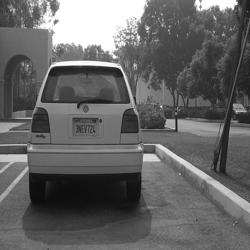

In [35]:
# Load all images from training dataset
training_images = [cv2.imread(file) for file in glob.glob("Training/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(training_images):
  training_images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load all images from test dataset
test_images = [cv2.imread(file) for file in glob.glob("Test/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(test_images):
  test_images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# DEBUG
if (VERBOSE_MODE):
  print(len(training_images), "training images loaded!")
  print(len(test_images), "test images loaded!")
  cv2_imshow(training_images[2])

# K-Means Clustering Implementation (Step 2) #

In [36]:
def getOptimumK(desc):
  sil = []
  base = 3
  kmax = 12

  for k in range(base, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(desc)
    labels = kmeans.labels_
    sil.append(silhouette_score(desc, labels, metric = 'euclidean'))

  plt.plot(range(base,kmax+1), sil, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Sum of squared distances/Intertia')
  plt.title('ehe')
  plt.show()

  print(sil)

  print(np.amax(sil))
  optimum_k = sil.index(np.amax(sil)) + base

  return optimum_k

GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb85229f870>, <KeyPoint 0x7fb8522a37b0>, <KeyPoint 0x7fb8522a3480>, <KeyPoint 0x7fb8522a3540>, <KeyPoint 0x7fb8522a36f0>, <KeyPoint 0x7fb8522b3840>, <KeyPoint 0x7fb852283d20>, <KeyPoint 0x7fb8522839c0>, <KeyPoint 0x7fb8522b3240>, <KeyPoint 0x7fb852283450>, <KeyPoint 0x7fb8522b3b70>, <KeyPoint 0x7fb8522b3600>, <KeyPoint 0x7fb85229fcc0>, <KeyPoint 0x7fb8522a35d0>, <KeyPoint 0x7fb8522b3390>, <KeyPoint 0x7fb8522b3870>, <KeyPoint 0x7fb85229f930>, <KeyPoint 0x7fb852283db0>, <KeyPoint 0x7fb85229fa50>, <KeyPoint 0x7fb852283870>, <KeyPoint 0x7fb852283210>, <KeyPoint 0x7fb85229f9c0>, <KeyPoint 0x7fb8522a3060>, <KeyPoint 0x7fb8522a3240>, <KeyPoint 0x7fb8522963c0>, <KeyPoint 0x7fb852

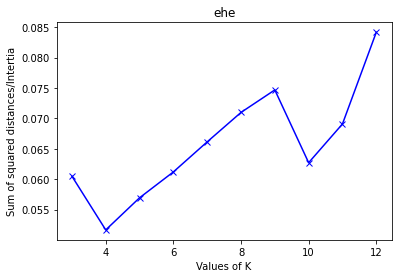

[0.06047815, 0.051642135, 0.056925975, 0.061181843, 0.066127256, 0.07096794, 0.07466743, 0.06269873, 0.069068864, 0.084155895]
0.084155895
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb852280540>, <KeyPoint 0x7fb85227a8d0>, <KeyPoint 0x7fb85227ab70>, <KeyPoint 0x7fb852280060>, <KeyPoint 0x7fb852278630>, <KeyPoint 0x7fb852296630>, <KeyPoint 0x7fb85b12f540>, <KeyPoint 0x7fb852330f30>, <KeyPoint 0x7fb852330d80>, <KeyPoint 0x7fb85227ab40>, <KeyPoint 0x7fb852330900>, <KeyPoint 0x7fb852226420>, <KeyPoint 0x7fb852278900>, <KeyPoint 0x7fb8522965a0>, <KeyPoint 0x7fb8522968a0>, <KeyPoint 0x7fb852226810>, <KeyPoint 0x7fb85fa987b0>, <KeyPoint 0x7fb852296570>, <KeyPoint 0x7fb852280cf0>, <KeyPoint 0x7fb8522800c0>, <KeyPoint 0x7f

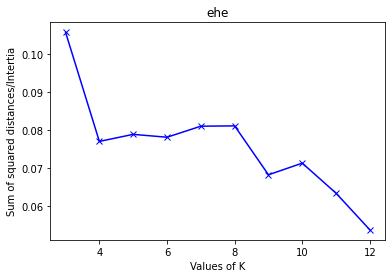

[0.10567425, 0.07704004, 0.0788973, 0.07814034, 0.08103386, 0.08111739, 0.06829276, 0.07134404, 0.06345721, 0.053834997]
0.10567425
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb852235ea0>, <KeyPoint 0x7fb852196420>, <KeyPoint 0x7fb852196780>, <KeyPoint 0x7fb8521cb570>, <KeyPoint 0x7fb8521cbcf0>, <KeyPoint 0x7fb8521cb3c0>, <KeyPoint 0x7fb8521cb630>, <KeyPoint 0x7fb8521cb7e0>, <KeyPoint 0x7fb852198330>, <KeyPoint 0x7fb8521cb600>, <KeyPoint 0x7fb852196300>, <KeyPoint 0x7fb852196150>, <KeyPoint 0x7fb8521cb990>, <KeyPoint 0x7fb8521cbe70>, <KeyPoint 0x7fb852198810>, <KeyPoint 0x7fb852196240>, <KeyPoint 0x7fb852196b10>, <KeyPoint 0x7fb8521985a0>, <KeyPoint 0x7fb852198570>, <KeyPoint 0x7fb85f7d3930>, <KeyPoint 0x7fb8521cb

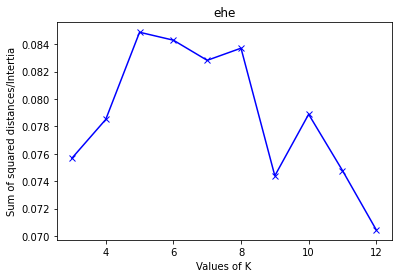

[0.07567996, 0.07850354, 0.08486365, 0.08428495, 0.082815684, 0.08370212, 0.074396625, 0.07888387, 0.07478147, 0.07044995]
0.08486365
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb8521041b0>, <KeyPoint 0x7fb852107d50>, <KeyPoint 0x7fb852107f00>, <KeyPoint 0x7fb852104150>, <KeyPoint 0x7fb852106b10>, <KeyPoint 0x7fb852198ed0>, <KeyPoint 0x7fb852106960>, <KeyPoint 0x7fb852108090>, <KeyPoint 0x7fb852188fc0>, <KeyPoint 0x7fb852106d80>, <KeyPoint 0x7fb852107180>, <KeyPoint 0x7fb852107270>, <KeyPoint 0x7fb852106db0>, <KeyPoint 0x7fb8521078d0>, <KeyPoint 0x7fb852108450>, <KeyPoint 0x7fb852188f30>, <KeyPoint 0x7fb8521071e0>, <KeyPoint 0x7fb852106ae0>, <KeyPoint 0x7fb8521048d0>, <KeyPoint 0x7fb8521073c0>, <KeyPoint 0x7fb8521

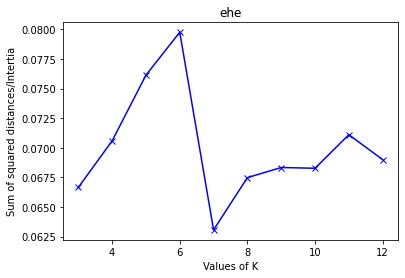

[0.06664936, 0.070580415, 0.07612795, 0.07975343, 0.063063495, 0.06747857, 0.06833272, 0.06826902, 0.07110531, 0.0689968]
0.07975343
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb85207a390>, <KeyPoint 0x7fb85207a450>, <KeyPoint 0x7fb85207acc0>, <KeyPoint 0x7fb8521f1db0>, <KeyPoint 0x7fb852079ea0>, <KeyPoint 0x7fb8521074e0>, <KeyPoint 0x7fb85207a7e0>, <KeyPoint 0x7fb8520790c0>, <KeyPoint 0x7fb85207ab70>, <KeyPoint 0x7fb85207b1b0>, <KeyPoint 0x7fb8520cf060>, <KeyPoint 0x7fb8520cf030>, <KeyPoint 0x7fb8520cf660>, <KeyPoint 0x7fb852188090>, <KeyPoint 0x7fb852079150>, <KeyPoint 0x7fb8522781e0>, <KeyPoint 0x7fb852278d50>, <KeyPoint 0x7fb85207af60>, <KeyPoint 0x7fb85207aea0>, <KeyPoint 0x7fb8520cf390>, <KeyPoint 0x7fb85207

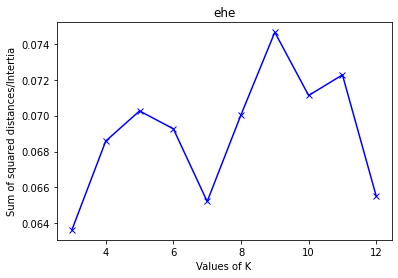

[0.06362874, 0.06858246, 0.07026314, 0.0692651, 0.06521432, 0.0700478, 0.07465032, 0.071124814, 0.07227344, 0.06550185]
0.07465032
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb8522350c0>, <KeyPoint 0x7fb852226db0>, <KeyPoint 0x7fb8521f11b0>, <KeyPoint 0x7fb852278cf0>, <KeyPoint 0x7fb8521a9e10>, <KeyPoint 0x7fb8521a9240>, <KeyPoint 0x7fb8521f1f60>, <KeyPoint 0x7fb852150060>, <KeyPoint 0x7fb8521501b0>, <KeyPoint 0x7fb8521a9f00>, <KeyPoint 0x7fb85f875b40>, <KeyPoint 0x7fb852235e10>, <KeyPoint 0x7fb8522785a0>, <KeyPoint 0x7fb852278210>, <KeyPoint 0x7fb852150630>, <KeyPoint 0x7fb852150720>, <KeyPoint 0x7fb8521a9210>, <KeyPoint 0x7fb8521a90c0>, <KeyPoint 0x7fb8521f1150>, <KeyPoint 0x7fb852235630>, <KeyPoint 0x7fb8521f10

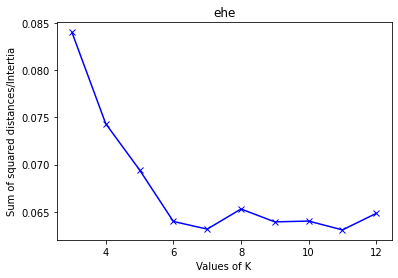

[0.0840251, 0.074329525, 0.069433406, 0.063965745, 0.063153766, 0.06528592, 0.063921764, 0.064007916, 0.06306953, 0.06482469]
0.0840251
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb85fa1fa50>, <KeyPoint 0x7fb85fa219f0>, <KeyPoint 0x7fb85fa1fc90>, <KeyPoint 0x7fb85fa9e240>, <KeyPoint 0x7fb85fa1d0c0>, <KeyPoint 0x7fb85207b510>, <KeyPoint 0x7fb85fa9eea0>, <KeyPoint 0x7fb85fa1f0f0>, <KeyPoint 0x7fb85fa9ed80>, <KeyPoint 0x7fb85fa21840>, <KeyPoint 0x7fb85fa80960>, <KeyPoint 0x7fb85fa807b0>, <KeyPoint 0x7fb85fa21720>, <KeyPoint 0x7fb85fa1f1b0>, <KeyPoint 0x7fb85fa1f540>, <KeyPoint 0x7fb85fa1f240>, <KeyPoint 0x7fb85fa1f8d0>, <KeyPoint 0x7fb852285690>, <KeyPoint 0x7fb85fa21cc0>, <KeyPoint 0x7fb85fa9e900>, <KeyPoint 0x7fb85

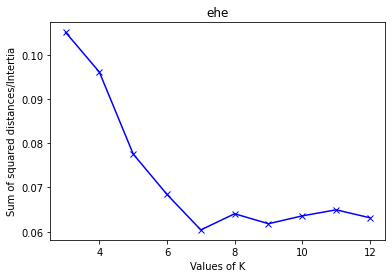

[0.10510694, 0.09610471, 0.07757437, 0.0684286, 0.060406063, 0.06406004, 0.061810084, 0.06358149, 0.064949244, 0.063155845]
0.10510694
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb8521706c0>, <KeyPoint 0x7fb852173cc0>, <KeyPoint 0x7fb852173cf0>, <KeyPoint 0x7fb852173b10>, <KeyPoint 0x7fb852145300>, <KeyPoint 0x7fb85af23f30>, <KeyPoint 0x7fb85af23db0>, <KeyPoint 0x7fb852173a50>, <KeyPoint 0x7fb85af23c90>, <KeyPoint 0x7fb85af23540>, <KeyPoint 0x7fb8521736f0>, <KeyPoint 0x7fb85af239c0>, <KeyPoint 0x7fb85213c810>, <KeyPoint 0x7fb852170b40>, <KeyPoint 0x7fb8521707e0>, <KeyPoint 0x7fb852170540>, <KeyPoint 0x7fb8521705a0>, <KeyPoint 0x7fb852139090>, <KeyPoint 0x7fb852139150>, <KeyPoint 0x7fb852170420>, <KeyPoint 0x7fb852

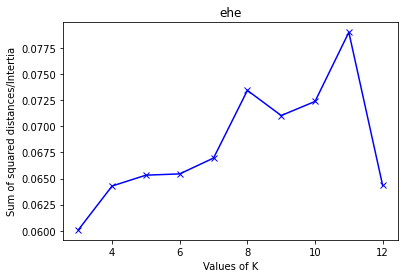

[0.06007754, 0.064289086, 0.06532557, 0.06544968, 0.06696865, 0.07345391, 0.0710438, 0.0723933, 0.0790296, 0.06434141]
0.0790296
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb8521dab70>, <KeyPoint 0x7fb8521e01b0>, <KeyPoint 0x7fb8521dcbd0>, <KeyPoint 0x7fb8521dc240>, <KeyPoint 0x7fb8522228d0>, <KeyPoint 0x7fb852222c90>, <KeyPoint 0x7fb85217f330>, <KeyPoint 0x7fb85217f4e0>, <KeyPoint 0x7fb8521e61b0>, <KeyPoint 0x7fb8521d55a0>, <KeyPoint 0x7fb8521e6180>, <KeyPoint 0x7fb8521dcde0>, <KeyPoint 0x7fb852150330>, <KeyPoint 0x7fb8521dc5d0>, <KeyPoint 0x7fb8521da810>, <KeyPoint 0x7fb8521da360>, <KeyPoint 0x7fb8521a4510>, <KeyPoint 0x7fb8521dc030>, <KeyPoint 0x7fb8521dc330>, <KeyPoint 0x7fb8521d5f00>, <KeyPoint 0x7fb8521e83f0

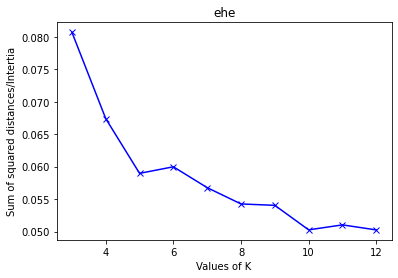

[0.08071509, 0.06740293, 0.058967333, 0.05997858, 0.056762908, 0.054250963, 0.054038562, 0.050260194, 0.05102553, 0.05024983]
0.08071509
GENERATING BASE IMAGE...
OK!
COMPUTING OCTAVES...
OK!
GENERATING KERNELS...
OK!
GENERATING GAUSSIAN IMAGES...
OK!
GENERATING DIFFERENCE OF GAUSSIAN IMAGES...
OK!
ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)
OK!
REMOVING DUPLICATE KEYPOINTS...
OK!
CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...
OK!
[<KeyPoint 0x7fb8520a3480>, <KeyPoint 0x7fb8520a1cc0>, <KeyPoint 0x7fb85209c270>, <KeyPoint 0x7fb8520a15d0>, <KeyPoint 0x7fb8520a15a0>, <KeyPoint 0x7fb8520a18a0>, <KeyPoint 0x7fb85207d8d0>, <KeyPoint 0x7fb85209c2d0>, <KeyPoint 0x7fb8520a10c0>, <KeyPoint 0x7fb852132c60>, <KeyPoint 0x7fb85af231e0>, <KeyPoint 0x7fb8520a18d0>, <KeyPoint 0x7fb8520a1930>, <KeyPoint 0x7fb8520a4a50>, <KeyPoint 0x7fb85209cae0>, <KeyPoint 0x7fb8520a3c00>, <KeyPoint 0x7fb85207d450>, <KeyPoint 0x7fb8520a1210>, <KeyPoint 0x7fb8520a1810>, <KeyPoint 0x7fb8520a4de0>, <KeyPoint 0x7fb8

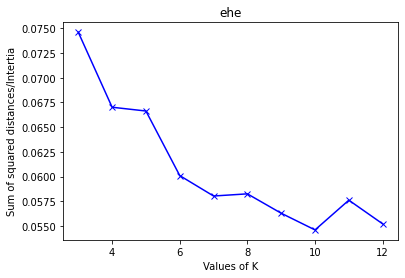

[0.07459882, 0.06701461, 0.06663208, 0.060100954, 0.058036044, 0.05825395, 0.056294087, 0.054606616, 0.057614155, 0.055218868]
0.07459882
Descriptors for training images: 5
Descriptors for test images: 5


In [38]:
# Get Optimum Ks

training_desc_array = []
test_desc_array = []

training_kp_array = []
test_kp_array = []

training_k_array = []
test_k_array = []


# Compute features and the optimum k values for each training image
for index, img in enumerate(training_images):
  kp, desc = computeKeypointsAndDescriptors(img)

  #print(desc)
  training_kp_array.append(kp)
  training_desc_array.append(desc)
  training_k_array.append(getOptimumK(desc))

# Compute features and the optimum k values for each test image
for index, img in enumerate(test_images):
  kp, desc = computeKeypointsAndDescriptors(img)

  test_kp_array.append(kp)
  test_desc_array.append(desc)
  test_k_array.append(getOptimumK(desc))

if (VERBOSE_MODE):
  print("Descriptors sets for training images:", len(training_desc_array))
  print("Descriptors sets for test images:", len(test_desc_array))


## Assign descriptors to nearest cluster for both the training and test images (Step 3.2) ##

In [91]:
# Stores the dictionary of clusters
final_dictionary = []

# Perform K-means clustering for each image
for image in range(len(training_images)):
  kmeans = KMeans(training_k_array[image]).fit(training_desc_array[image])

  kmeans.predict(training_desc_array[image])

  print("CENTRE")
  #print(len(kmeans.cluster_centers_))
  #print(kmeans.cluster_centers_[2])
  #print(kmeans.labels_)

  cluster = []


  for k in range(training_k_array[image]):
    #print("Operating on Cluster", k)
    #print(kmeans.labels_)
    data = []
    for i in range(len(kmeans.labels_)):
      #print("Operating on d-value", i)
      if kmeans.labels_[i] == k:
        #print("Match found!")
        data.append(training_desc_array[image][i])
        #print(training_desc_array[image][i])
    cluster.append(data)

  print(len(cluster[0]))

  final_dictionary.append(cluster)



print(len(final_dictionary[0]))

sum = 0
for i, x in enumerate(final_dictionary):
  print("Size of cluster", i, " is", len(x))
  sum += len(final_dictionary[i])

print("Sum:", sum)


CENTRE
22
CENTRE
121
CENTRE
56
CENTRE
66
CENTRE
22
12
Size of cluster 0  is 12
Size of cluster 1  is 3
Size of cluster 2  is 5
Size of cluster 3  is 6
Size of cluster 4  is 9
Sum: 35


## Step 3 - Visualise Histograms ##

In [77]:
def build_histogram(descriptor_list, cluster_alg, c_result):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result = c_result
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram
  

# Create histograms for the test images
test_preprocessed_images = []
for i, image in enumerate(test_images):
      if (test_desc_array[i] is not None):

          kmeans = KMeans(test_k_array[i])
          kmeans.fit(test_desc_array[i])
          y_kmeans = kmeans.predict(test_desc_array[i])

          histogram = build_histogram(test_desc_array[i], kmeans, y_kmeans)
          test_preprocessed_images.append(histogram)

training_preprocessed_images = []
# Create histograms for the training images
for i, image in enumerate(training_images):
      if (training_desc_array[i] is not None):

          kmeans = KMeans(training_k_array[i])
          kmeans.fit(training_desc_array[i])
          y_kmeans = kmeans.predict(training_desc_array[i])

          histogram = build_histogram(training_desc_array[i], kmeans, y_kmeans)
          training_preprocessed_images.append(histogram)


Test hist


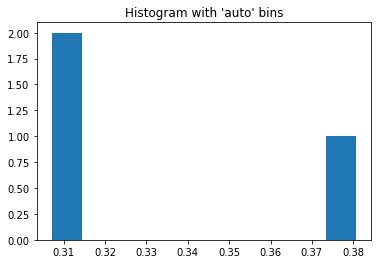

Test hist


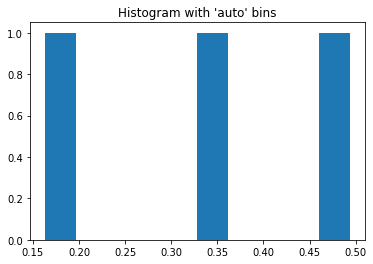

Test hist


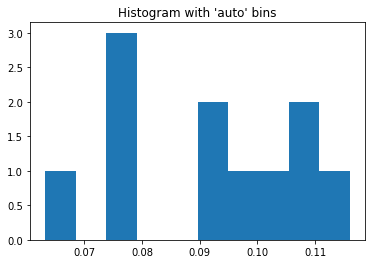

Test hist


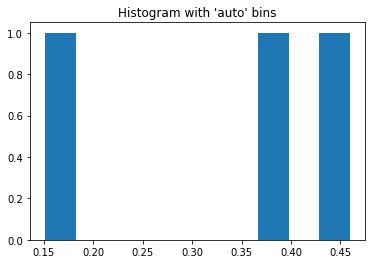

Test hist


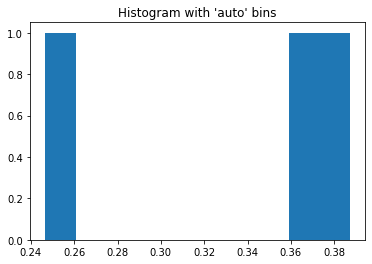

Train images


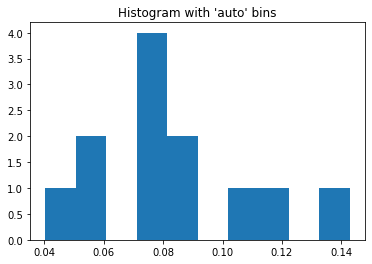

Train images


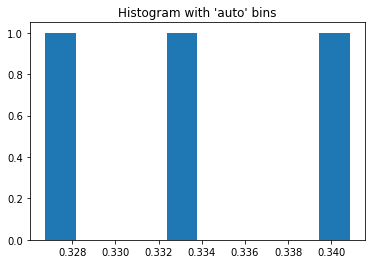

Train images


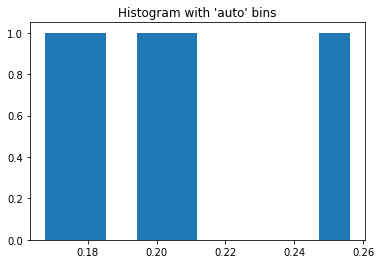

Train images


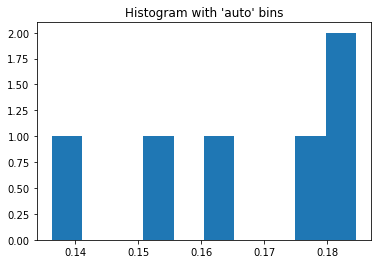

Train images


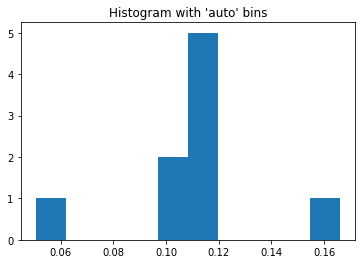

In [78]:
for hist_test in test_preprocessed_images:
  print("Test hist")

  hist_norm_test = hist_test/sum(hist_test)
  plt.hist(hist_norm_test)
  plt.title("Histogram with 'auto' bins")
  plt.show()


for hist_train in training_preprocessed_images:


#Normalize the histogram
  print("Train images")
  hist_norm_train = hist_train/sum(hist_train)
  plt.hist(hist_norm_train)
  plt.title("Histogram with 'auto' bins")
  plt.show()


In [ ]:
'''
# Distanecs for each cluster
for s in range(len(set_of_dictionaries)):
  print("Image ", s)
  for c in range(len(set_of_dictionaries[s])):
    print("Cluster ", c)
    #km = KMeans[]
    for d in set_of_dictionaries[c][s]:
      # Find distances
      
      pass#print(d)
'''
for i, s in enumerate(set_of_dictionaries):
  print("IMAGE ", i)
  for z, d in enumerate(s):
    print("CLUSTER ", z)
    for x, c in enumerate(d):
      print("DISTANCE ", x, " = ", c)

## Step 4 ##


In [83]:
data = []
labels = []

for i in hist_norm_train:
  data.append(i)
  labels.append(0)

for i in hist_norm_test:
  data.append(i)
  labels.append(1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("train x", X_train)
print("test x", X_test)
print("test y", y_train)

def L2_NN(trainx, trainy, testx):
  testy_L2 = []
  for i in range(len(testx)):
    #calculae the L2 distance
    distance = [np.sum(np.square(testx[i]-trainx[j])) for j in range(len(trainx))]
    test_predicted = trainy[np.argmin(distance)]
    testy_L2.append(test_predicted)
  
  return np.asarray(testy_L2)



#prediction
testy_L2 = L2_NN(X_train, y_train,X_test)

print(testy_L2)





train x [0.11191335740072202, 0.16606498194945848, 0.11552346570397112, 0.11552346570397112, 0.36622390891840606, 0.11913357400722022, 0.09747292418772563, 0.05054151624548736, 0.11913357400722022]
test x [0.24667931688804554, 0.3870967741935484, 0.10469314079422383]
test y [0, 0, 0, 0, 1, 0, 0, 0, 0]
[0 1 0]


## Part 5 - Calculate the error rate ##



In [84]:
def error_rate(testy, testy_fit):
  return float(sum(testy!=testy_fit))/len(testy)

print("Error rate:", error_rate(y_test, testy_L2))

Error rate: 0.3333333333333333


## Part 5 - Confusion Matrix ##

In [86]:
def confusionMatrix(testy, testy_fit):
  matrix_dimension = len(np.unique(testy))
  confusionMatrix = np.zeros((matrix_dimension, matrix_dimension))
  for i in range(len(testy)):
    confusionMatrix[int(testy[i])][int(testy_fit[i])] +=1

  return confusionMatrix


confusionMatrix(y_test, testy_L2)

array([[1., 0.],
       [1., 1.]])